In [31]:
from collections import defaultdict, Counter, namedtuple
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats
import random
import copy

In [32]:
chroms = [str(x) for x in range(1, 23)]
#chroms = ['18']
ihart_family_sizes = [3, 4, 5, 6]
ihart_phase_dir = '../phased_ihart_males_only'
ssc_family_sizes = [3, 4]
ssc_phase_dir = '../phased_ssc'

In [33]:
ped_files = ['../data/160826.ped', '../data/ssc.ped']
# Affection (0=unknown; 1=unaffected; 2=affected)
child_id_to_affected = dict()
child_id_to_sex = dict()
fam_to_inds = dict()

for ped_file in ped_files:
    with open(ped_file, 'r') as f:
        for line in f:
            pieces = line.strip().split('\t')
            if len(pieces) >= 6:
                fam_id, child_id, f_id, m_id, sex, disease_status = pieces[0:6]
                famkey = '.'.join((fam_id, m_id, f_id))
                if famkey not in fam_to_inds:
                    fam_to_inds[famkey] = [m_id, f_id]
                fam_to_inds[famkey].append(child_id)
                child_id_to_affected[child_id] = disease_status
                child_id_to_sex[child_id] = sex

In [34]:
# From GRCh37.p13 https://www.ncbi.nlm.nih.gov/grc/human/data?asm=GRCh37.p13
chrom_lengths = {
	'1': 249250621,
	'2': 243199373,
	'3': 198022430,
	'4': 191154276,
	'5': 180915260,
	'6': 171115067,
	'7': 159138663,
	'8': 146364022,
	'9': 141213431,
	'10': 135534747,
	'11': 135006516,
	'12': 133851895,
	'13': 115169878,
	'14': 107349540,
	'15': 102531392,
	'16': 90354753,
	'17': 81195210,
	'18': 78077248,
	'19': 59128983,
	'20': 63025520,
	'21': 48129895,
	'22': 51304566,
	'X': 155270560,
	'Y': 59373566
}

chrom_offsets = [0]
for chrom in chroms:
    chrom_offsets.append(chrom_offsets[-1]+chrom_lengths[chrom])
print(chrom_offsets)

[0, 249250621, 492449994, 690472424, 881626700, 1062541960, 1233657027, 1392795690, 1539159712, 1680373143, 1815907890, 1950914406, 2084766301, 2199936179, 2307285719, 2409817111, 2500171864, 2581367074, 2659444322, 2718573305, 2781598825, 2829728720, 2881033286]


# Filter Families


In [35]:
family_to_individuals = dict()

def load_families(phase_dir, family_sizes):
    family_to_chroms = defaultdict(set)
    
    for chrom in chroms:
        print(chrom, end=' ')

        for j in family_sizes:
            try:
                with open('%s/chr.%s.familysize.%d.families.txt' % (phase_dir, chrom, j), 'r') as f:
                    next(f) # skip header
                    for line in f:
                        pieces = line.strip().split('\t')
                        family_key = pieces[0]
                        family_to_chroms[family_key].add(chrom)
                        family_to_individuals[family_key] = pieces[1:(1+j)]
            except FileNotFoundError:
                print('File not found', 'chrom', chrom, 'family size', j)
            except StopIteration:
                print('File empty', 'chrom', chrom, 'family size', j)

    families_to_include = set([k for k, v in family_to_chroms.items() if len(v)==len(chroms)])
    print('Families with all chroms', len(families_to_include))
    print(Counter([len(v) for v in family_to_chroms.values()]))
    return families_to_include
ihart_families = load_families(ihart_phase_dir, ihart_family_sizes)
ssc_families = load_families(ssc_phase_dir, ssc_family_sizes)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 Families with all chroms 830
Counter({22: 830})
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 Families with all chroms 519
Counter({22: 519})


In [36]:
# filter SSC to have only males
ssc_families = [famkey for famkey in ssc_families if len(family_to_individuals[famkey])==4 and child_id_to_sex[family_to_individuals[famkey][2]] == '1' and child_id_to_sex[family_to_individuals[famkey][3]] == '1']
print(len(ssc_families))



206


In [37]:
ihart_individuals = sorted(sum([family_to_individuals[k] for k in ihart_families], []))
ihart_ind_to_index = dict([(x, i) for i, x in enumerate(ihart_individuals)])
ssc_individuals = sorted(sum([family_to_individuals[k] for k in ssc_families], []))
ssc_ind_to_index = dict([(x, i) for i, x in enumerate(ssc_individuals)])

# Read in deletions


In [38]:
Deletion = namedtuple('Deletion', ['family', 'chrom', 'start_pos', 'end_pos', 'length', 'opt_start_pos', 'opt_end_pos', 'trans', 'notrans', 
                                      'family_size', 'is_mat', 'is_pat', 'state', 'dataset'])



In [39]:
from collections import defaultdict

def read_deletions(chrom, phase_dir, family_sizes, families, dataset):
    deletions = []

    for j in family_sizes:
            
        # load deletions
        family_to_states = defaultdict(list)
        family_to_pos = defaultdict(list)
        with open('%s/chr.%s.familysize.%d.phased.txt' % (phase_dir, chrom, j), 'r')  as f:
            next(f) # skip header

            for line in f:
                pieces = line.strip().split('\t')
                family_key = pieces[0]
                if family_key in families:
                    state = [int(x) for x in pieces[1:(2+(j*2))]]
                    start_pos, end_pos = [int(x) for x in pieces[(2+(j*2)):(4+(j*2))]]
                    assert end_pos >= start_pos
                        
                    # if a segment is never inherited, we don't know if it has a deletion or not
                    if state[0] == 0 and state[1] == 0:
                        pass
                    else:
                        if len([i for i in range(4, len(state)-1, 2) if state[i]==0]) == 0:
                            state[0] = -1
                        if len([i for i in range(4, len(state)-1, 2) if state[i]==1]) == 0:
                            state[1] = -1
                    if state[2] == 0 and state[3] == 0:
                        pass
                    else:
                        if len([i for i in range(5, len(state)-1, 2) if state[i]==0]) == 0:
                            state[2] = -1
                        if len([i for i in range(5, len(state)-1, 2) if state[i]==1]) == 0:
                            state[3] = -1

                    family_to_states[family_key].append(state)
                    family_to_pos[family_key].append((start_pos, end_pos))

        # for each family, detect deletion transmission
        for family_key, states in family_to_states.items():
            states = np.asarray(states)
            assert np.all(states[0, :4] != 0)
            assert np.all(states[-1, :4] != 0)
            positions = np.asarray(family_to_pos[family_key])
            inds = family_to_individuals[family_key]

            # for each ancestral chromosome
            for anc in range(4):
                is_mat = anc==0 or anc==1
                is_pat = anc==2 or anc==3
                    
                start_indices = np.where((states[:-1, anc] != 0) & (states[1:, anc] == 0))[0]+1
                end_indices = np.where((states[:-1, anc] == 0) & (states[1:, anc] != 0))[0]+1
                for s_ind, e_ind in zip(start_indices, end_indices):
                    
                    # check if parental double deletion
                    if is_mat:
                        is_double = np.all(states[s_ind, :2]==0)
                    else:
                        is_double = np.all(states[s_ind, 2:4]==0)
        
                    # check if recombination event occured and that inheritance state is known
                    has_recomb = False
                    if is_mat:
                        indices = np.arange(4, states.shape[1]-1, 2)
                    else:
                        indices = np.arange(5, states.shape[1]-1, 2)
                        
                    inh_known = np.all(states[s_ind:e_ind, indices] != -1)
                        
                    for i in range(s_ind, e_ind):
                        if np.any(states[i, indices] != states[s_ind, indices]):
                            has_recomb = True
                            
                    # check if in ok region
                    ok_region = np.all(states[s_ind:e_ind, -1] == 0)
                    
                    if ok_region and inh_known and (not has_recomb):
                        start_pos, end_pos = positions[s_ind, 0], positions[e_ind-1, 1]
                        
                        # find boundaries of the deletion
                        #print(s_ind, e_ind)
                        opt_start_index = s_ind
                        while states[opt_start_index, anc] != 1 and opt_start_index > 0:
                            opt_start_index -= 1
                        opt_start_pos = positions[opt_start_index+1, 0]
                        
                        opt_end_index = e_ind
                        while(states[opt_end_index, anc]) != 1 and opt_end_index < states.shape[0]-1:
                            opt_end_index += 1
                        opt_end_pos = positions[e_ind-1, 1]
                        
                        assert start_pos <= end_pos
                        assert opt_start_pos <= start_pos
                        assert end_pos <= opt_end_pos
                        
                        state = states[s_ind, :]
                    
                        # children
                        trans, notrans = [], []
                        for k, child in zip(range(2, j), inds[2:]):
                            mom_s, dad_s = state[(2*k):(2*(k+1))]

                            if is_mat:
                                assert mom_s != -1
                                if anc==mom_s:
                                    trans.append(child)
                                else:
                                    notrans.append(child)
                            if is_pat:
                                assert dad_s != -1
                                if anc==2+dad_s:
                                    trans.append(child)
                                else:
                                    notrans.append(child)

                        if (len(trans) + len(notrans) == j-2) and (len(trans) > 0):
                            deletions.append(Deletion(family_key, chrom, start_pos, end_pos, end_pos-start_pos+1,
                                                      opt_start_pos, opt_end_pos,
                                                              tuple(trans), tuple(notrans), j, is_mat, is_pat,
                                                              tuple(states[s_ind, :]), dataset))
                        
    # sort deletions
    deletions = sorted(deletions, key=lambda x: x.start_pos)
    return deletions



In [40]:
class DeletionCollection:
    def __init__(self, deletion, matches):
        self.deletion = deletion
        self.matches = matches

def create_collections(deletions):
    collections = []
    
    starts = np.array([d.start_pos for d in deletions])
    stops = np.array([d.end_pos for d in deletions])

    ordered_start_indices = np.argsort(starts)
    ordered_starts = starts[ordered_start_indices]
    ordered_stop_indices = np.argsort(stops)
    ordered_stops = stops[ordered_stop_indices]
        
    insert_starts_in_stops = np.searchsorted(ordered_stops, starts)
    insert_stops_in_starts = np.searchsorted(ordered_starts, stops, side='right')
        
    indices = np.ones((len(deletions),), dtype=bool)

    for del_index, main_d in enumerate(deletions):
        indices[:] = True
        indices[ordered_stop_indices[:insert_starts_in_stops[del_index]]] = False
        indices[ordered_start_indices[insert_stops_in_starts[del_index]:]] = False

        collections.append(DeletionCollection(main_d, [deletions[j] for j in np.where(indices)[0]]))
    return collections



In [41]:
def prune_deletions(collections, share_cutoff=0.8):    
    # first, prune deletions that don't overlap with the main deletion by share_cutoff
    for c in collections:
        lengths = np.array([d.length for d in c.matches])
        overlaps1 = np.array([min(d.opt_end_pos, c.deletion.end_pos)-max(d.opt_start_pos, c.deletion.start_pos)+1 for d in c.matches])
        overlaps2 = np.array([min(d.end_pos, c.deletion.opt_end_pos)-max(d.start_pos, c.deletion.opt_start_pos)+1 for d in c.matches])
        c.matches = set([c.matches[j] for j in np.where((overlaps2 >= share_cutoff*lengths) & (overlaps1 >= share_cutoff*c.deletion.length))[0]])
    return collections

def prune_collections(collections):
        
    deletion_to_index = dict([(x.deletion, i) for i, x in enumerate(collections)])
    
    # now, get rid of collections that are identical to other collections
    for c in collections:
        if c is not None:
            for d in c.matches:
                index = deletion_to_index[d]
                if (c.deletion != d) and (collections[index] is not None) and (c.matches == collections[index].matches):
                    collections[index] = None
    #print('removing %d of %d' % (len([x for x in collections if x is None]), len(collections)))
    collections = [x for x in collections if x is not None]
    return collections





In [42]:
all_collections = []
for chrom in chroms:
    print(chrom, end=' ')
    
    ihart_deletions = read_deletions(chrom, ihart_phase_dir, ihart_family_sizes, ihart_families, 'iHART')
    print('id', end=' ')
    
    ssc_deletions = read_deletions(chrom, ssc_phase_dir, ssc_family_sizes, ssc_families, 'SSC')
    print('sd', end=' ')
    
    deletions = sorted(ihart_deletions + ssc_deletions, key=lambda x: x.start_pos)
    collections = create_collections(deletions)
    print('c', end=' ')
    
    collections = prune_deletions(collections)
    print('p', end=' ')
    
    collections = prune_collections(collections)
    print(len(collections))
    
    all_collections.append(collections)    
    

1 id sd c p 3449
2 id sd c p 2449
3 id sd c p 2436
4 id sd c p 3132
5 id sd c p 1854
6 id sd c p 3941
7 id sd c p 2571
8 id sd c p 2519
9 id sd c p 2197
10 id sd c p 1561
11 id sd c p 2331
12 id sd c p 2224
13 id sd c p 1112
14 id sd c p 1894
15 id sd c p 1663
16 id sd c p 1192
17 id sd c p 1038
18 id sd c p 778
19 id sd c p 1911
20 id sd c p 613
21 id sd c p 555
22 id sd c p 805


# Modified TDT

In [43]:
def create_contingency(collections, family_sizes, filter_child, verbose=True):
    # chrom, collection, family_size, notrans/trans
    contingency = [np.zeros((len(collections[i]), len(family_sizes), 2)) for i in range(len(chroms))]
    familysize_to_index = dict([(x, i) for i, x in enumerate(family_sizes)])
    for i, chrom in enumerate(chroms):
        if verbose:
            print(chrom, end=' ')
        for j, c in enumerate(collections[i]):
            for k, s in enumerate(family_sizes):
                contingency[i][j, k, 0] = sum([len([x for x in d.notrans if filter_child(x, d.is_mat, d.dataset)]) for d in c.matches if d.family_size==s])
                contingency[i][j, k, 1] = sum([len([x for x in d.trans if filter_child(x, d.is_mat, d.dataset)]) for d in c.matches if d.family_size==s])
    return contingency

contingency_both_aff = create_contingency(all_collections, ihart_family_sizes, lambda child_id, is_mat, dataset: child_id_to_affected[child_id]=='2' and child_id_to_sex[child_id]=='1')
contingency_both_unaff = create_contingency(all_collections, ihart_family_sizes, lambda child_id, is_mat, dataset: child_id_to_affected[child_id]=='1' and child_id_to_sex[child_id]=='1')

contingency_ihart_aff = create_contingency(all_collections, ihart_family_sizes, lambda child_id, is_mat, dataset: child_id_to_affected[child_id]=='2' and dataset=='iHART' and child_id_to_sex[child_id]=='1')
contingency_ihart_unaff = create_contingency(all_collections, ihart_family_sizes, lambda child_id, is_mat, dataset: child_id_to_affected[child_id]=='1' and dataset=='iHART' and child_id_to_sex[child_id]=='1')

contingency_ssc_aff = create_contingency(all_collections, ihart_family_sizes, lambda child_id, is_mat, dataset: child_id_to_affected[child_id]=='2' and dataset=='SSC' and child_id_to_sex[child_id]=='1')
contingency_ssc_unaff = create_contingency(all_collections, ihart_family_sizes, lambda child_id, is_mat, dataset: child_id_to_affected[child_id]=='1' and dataset=='SSC' and child_id_to_sex[child_id]=='1')



1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 

In [44]:
import bayesian_transmission_rate as btr
import importlib
importlib.reload(btr)

transrates_both_aff = [btr.calculate_transmission_rates(contingency_both_aff[i], ihart_family_sizes) for i in range(len(chroms))]
transrates_both_unaff = [btr.calculate_transmission_rates(contingency_both_unaff[i], ihart_family_sizes) for i in range(len(chroms))]

transrates_ihart_aff = [btr.calculate_transmission_rates(contingency_ihart_aff[i], ihart_family_sizes) for i in range(len(chroms))]
transrates_ihart_unaff = [btr.calculate_transmission_rates(contingency_ihart_unaff[i], ihart_family_sizes) for i in range(len(chroms))]
              
transrates_ssc_aff = [btr.calculate_transmission_rates(contingency_ssc_aff[i], ihart_family_sizes) for i in range(len(chroms))]
transrates_ssc_unaff = [btr.calculate_transmission_rates(contingency_ssc_unaff[i], ihart_family_sizes) for i in range(len(chroms))]
            

In [45]:
ind_indices = [np.ones((len(all_collections[i]),), dtype=bool) for i in range(len(chroms))]
for i, chrom in enumerate(chroms):
    used_deletions = set()
    for j in np.flip(np.argsort([sum([len(d.trans)+len(d.notrans) for d in c.matches]) for c in all_collections[i]])):
        c = all_collections[i][j]
        ind_indices[i][j] = np.all([x not in used_deletions for x in c.matches])
        if ind_indices[i][j]:
            used_deletions.update(c.matches)
    print(np.sum(ind_indices[i]))

1922
1503
1442
1610
1192
1831
1425
1465
1307
917
1293
1098
626
1191
919
702
582
504
863
384
371
450


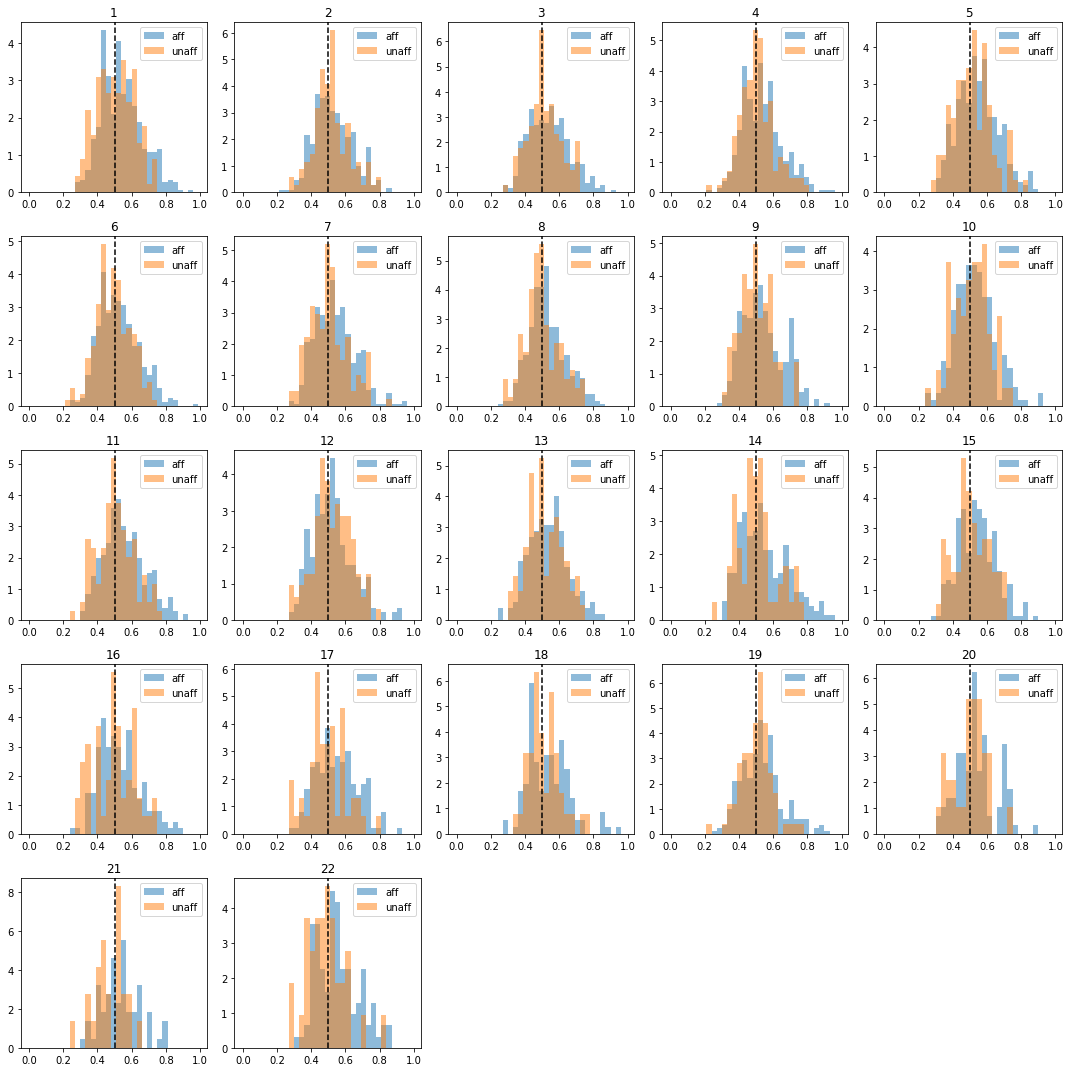

In [46]:
plt.figure(figsize=(15, 15))

for i, chrom in enumerate(chroms):
    
    deletion_to_index = dict([(x.deletion, j) for j, x in enumerate(all_collections[i])])

    plt.subplot(5, 5, i+1)
    plt.hist(transrates_ihart_aff[i][ind_indices[i]], bins=np.arange(0, 1, 0.03), alpha=0.5, label='aff', density=True)
    plt.hist(transrates_ihart_unaff[i][ind_indices[i]], bins=np.arange(0, 1, 0.03), alpha=0.5, label='unaff', density=True)

    plt.axvline(0.5, color='black', linestyle='--')
    plt.legend()
    plt.title(chrom)
    
plt.tight_layout()
plt.show()

In [47]:
print(np.hstack(ind_indices).shape)
print(np.hstack(transrates_ihart_aff).shape)

(42225,)
(42225,)


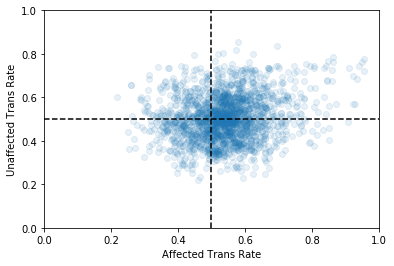

In [48]:
plt.scatter(np.hstack(transrates_ihart_aff)[np.hstack(ind_indices)], np.hstack(transrates_ihart_unaff)[np.hstack(ind_indices)], alpha=0.1)
plt.xlabel('Affected Trans Rate')
plt.ylabel('Unaffected Trans Rate')
plt.axhline(0.5, color='black', linestyle='--')
plt.axvline(0.5, color='black', linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])

plt.show()

In [49]:
importlib.reload(btr)

#ihart
posteriors_ihart_aff = [btr.calculate_posteriors(contingency_ihart_aff[i], ihart_family_sizes) for i in range(len(chroms))]
posteriors_ihart_unaff = [btr.calculate_posteriors(contingency_ihart_unaff[i], ihart_family_sizes) for i in range(len(chroms))]

#ssc
posteriors_ssc_aff = [btr.calculate_posteriors(contingency_ssc_aff[i], ihart_family_sizes) for i in range(len(chroms))]
posteriors_ssc_unaff = [btr.calculate_posteriors(contingency_ssc_unaff[i], ihart_family_sizes) for i in range(len(chroms))]

#both
posteriors_both_aff = [btr.calculate_posteriors(contingency_both_aff[i], ihart_family_sizes) for i in range(len(chroms))]
posteriors_both_unaff = [btr.calculate_posteriors(contingency_both_unaff[i], ihart_family_sizes) for i in range(len(chroms))]


In [50]:
importlib.reload(btr)

overlap_ihart = [btr.calculate_posterior_overlap(posteriors_ihart_aff[i], posteriors_ihart_unaff[i]) for i in range(len(chroms))]
print(np.min([np.min(overlap_ihart[i]) for i in range(len(chroms))]))

overlap_ssc = [btr.calculate_posterior_overlap(posteriors_ssc_aff[i], posteriors_ssc_unaff[i]) for i in range(len(chroms))]
print(np.min([np.min(overlap_ssc[i]) for i in range(len(chroms))]))

overlap_both = [btr.calculate_posterior_overlap(posteriors_both_aff[i], posteriors_both_unaff[i]) for i in range(len(chroms))]
print(np.min([np.min(overlap_both[i]) for i in range(len(chroms))]))



0.035662951792469984
0.009284278458248314
0.014596411375680554


//anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


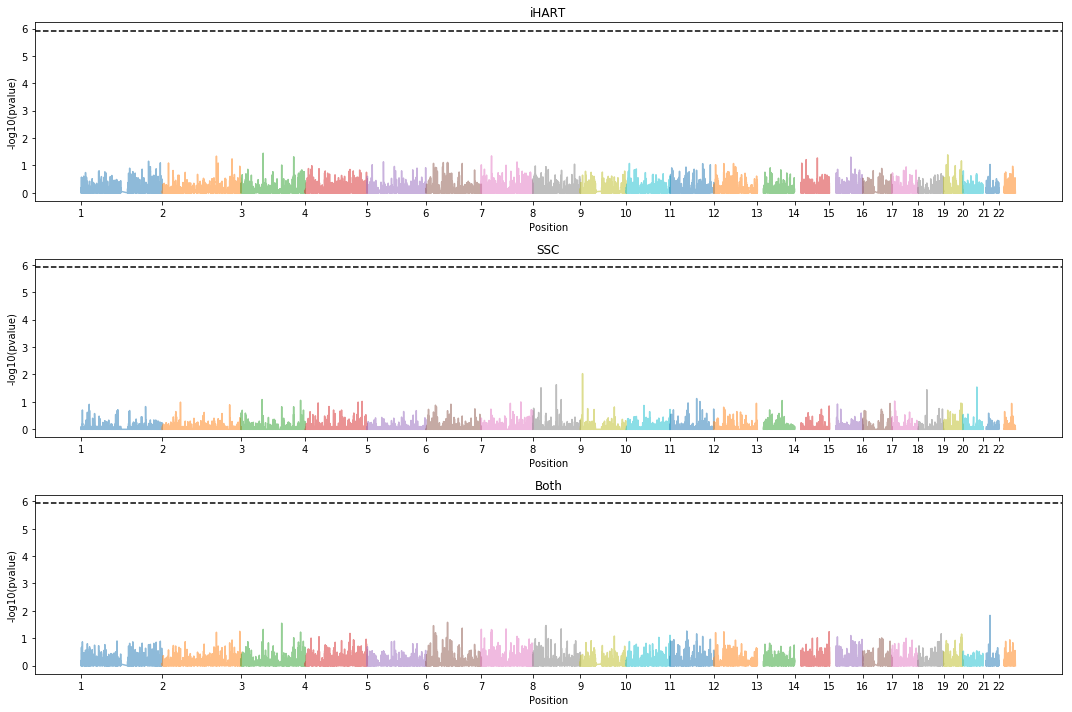

In [51]:
plt.figure(figsize=(15, 10))
 
cutoff = -np.log10(0.05/sum([len(contingency_both_aff[i]) for i in range(len(chroms))]))
#cutoff = -np.log10(0.05/len(all_collections))

plt.subplot(3, 1, 1)
plt.axhline(cutoff, linestyle='--', color='black')
plt.ylabel('-log10(pvalue)')
plt.xlabel('Position')
plt.xticks(chrom_offsets[:-1], chroms)
plt.title('iHART')

plt.subplot(3, 1, 2)
plt.axhline(cutoff, linestyle='--', color='black')
plt.ylabel('-log10(pvalue)')
plt.xlabel('Position')
plt.xticks(chrom_offsets[:-1], chroms)
plt.title('SSC')

plt.subplot(3, 1, 3)
plt.axhline(cutoff, linestyle='--', color='black')
plt.ylabel('-log10(pvalue)')
plt.xlabel('Position')
plt.xticks(chrom_offsets[:-1], chroms)
plt.title('Both')

for i, chrom in enumerate(chroms):
    positions = chrom_offsets[i] + np.array([c.deletion.start_pos for c in all_collections[i]])
    plt.subplot(3, 1, 1)
    plt.plot(positions, -np.log10(overlap_ihart[i]),label='iHART', alpha=0.5)
    plt.subplot(3, 1, 2)
    plt.plot(positions, -np.log10(overlap_ssc[i]),label='SSC', alpha=0.5)
    plt.subplot(3, 1, 3)
    plt.plot(positions, -np.log10(overlap_both[i]),label='Both', alpha=0.5)

plt.tight_layout()
plt.show()

In [52]:
#ihart
posterior_pvalues_ihart_aff = [btr.calculate_posterior_pvalue(posteriors_ihart_aff[i]) for i in range(len(chroms))]
posterior_pvalues_ihart_unaff =  [btr.calculate_posterior_pvalue(posteriors_ihart_unaff[i]) for i in range(len(chroms))]

#ssc
posterior_pvalues_ssc_aff =  [btr.calculate_posterior_pvalue(posteriors_ssc_aff[i]) for i in range(len(chroms))]
posterior_pvalues_ssc_unaff =  [btr.calculate_posterior_pvalue(posteriors_ssc_unaff[i]) for i in range(len(chroms))]

#both
posterior_pvalues_both_aff =  [btr.calculate_posterior_pvalue(posteriors_both_aff[i]) for i in range(len(chroms))]
posterior_pvalues_both_unaff =  [btr.calculate_posterior_pvalue(posteriors_both_unaff[i]) for i in range(len(chroms))]


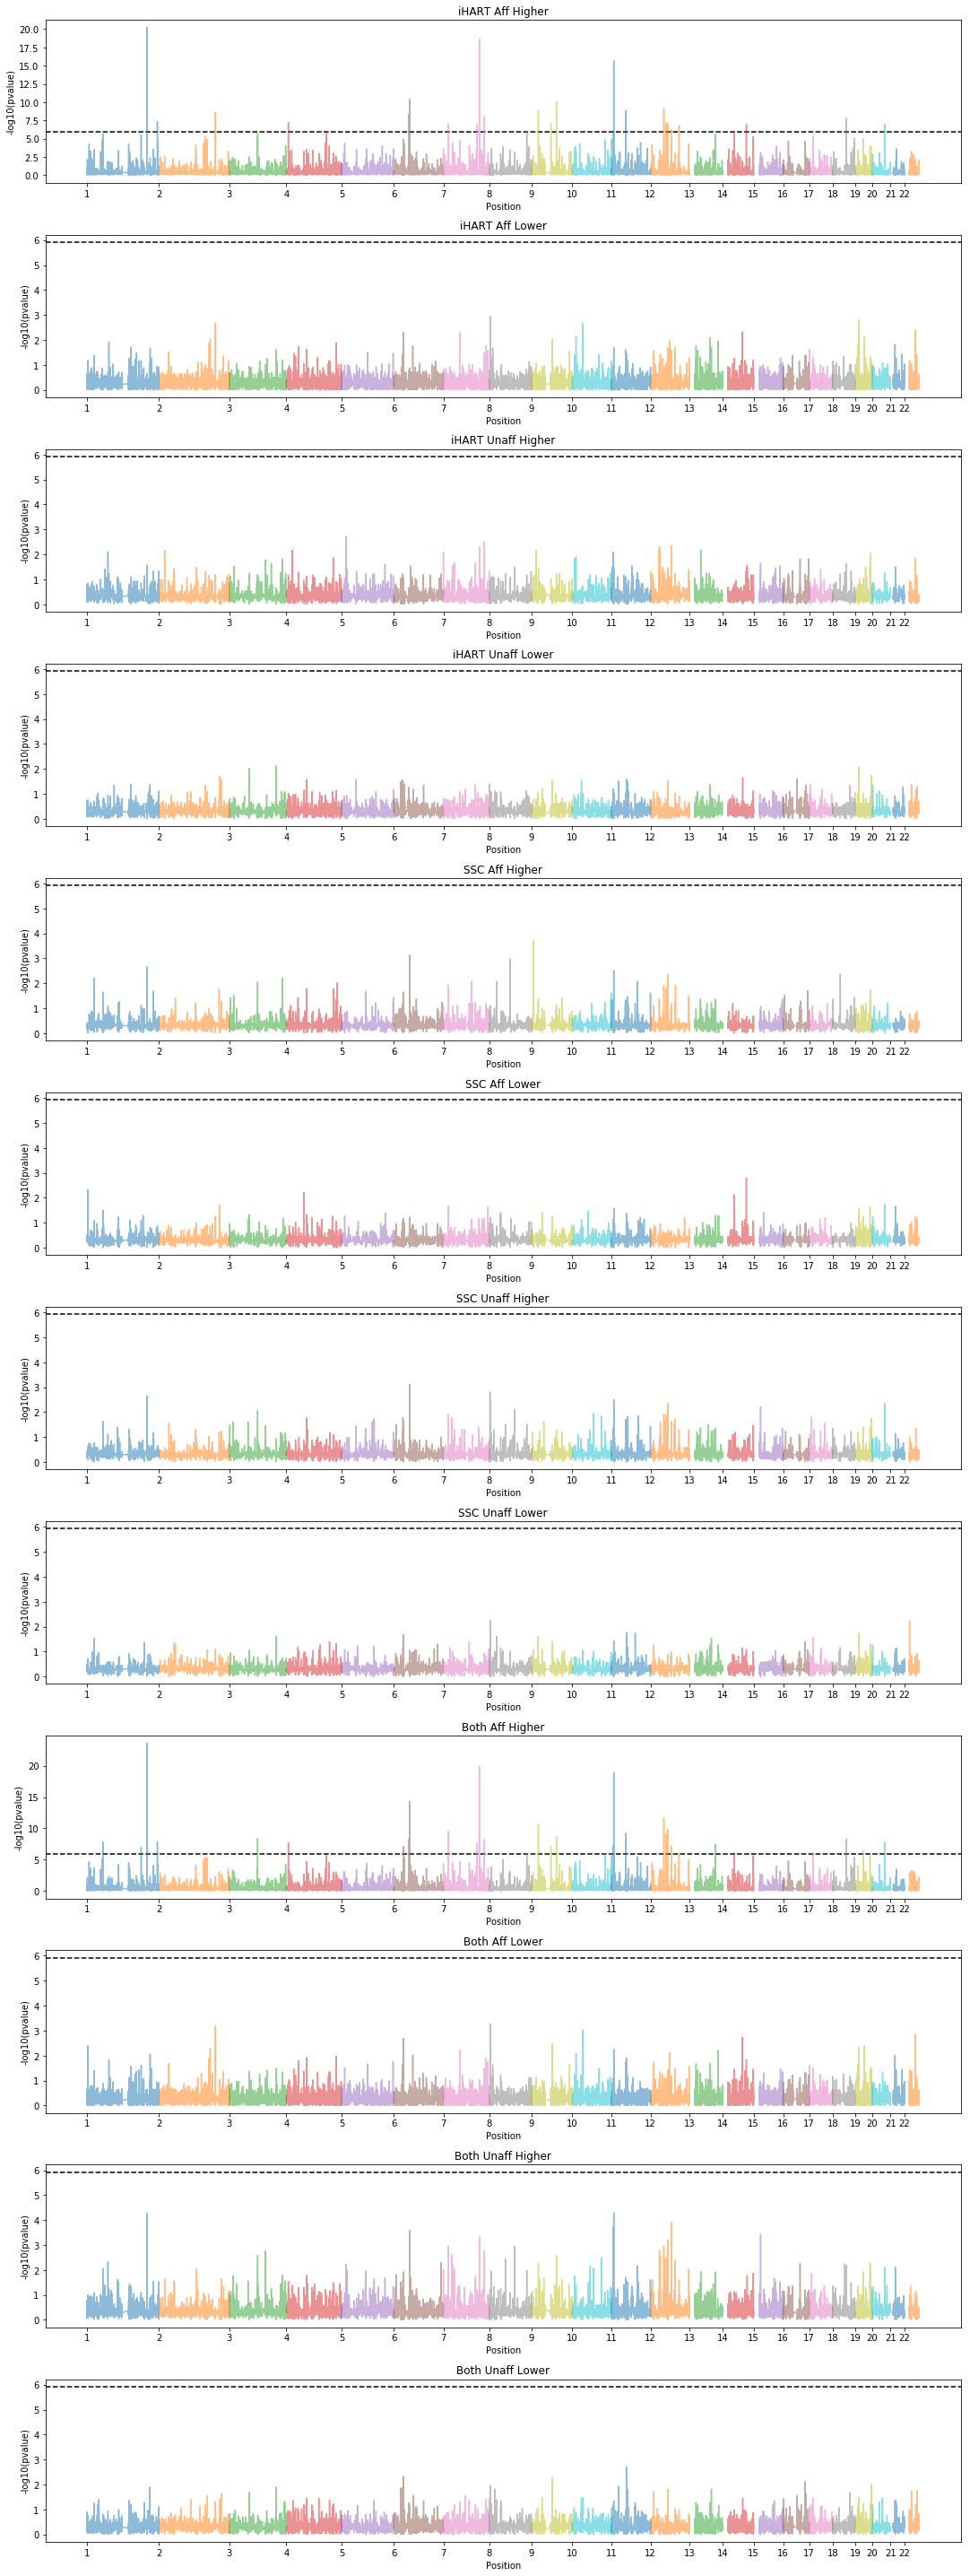

In [53]:
plt.figure(figsize=(15, 40))
 
cutoff = -np.log10(0.05/sum([len(contingency_both_aff[i]) for i in range(len(chroms))]))
#cutoff = -np.log10(0.05/len(all_collections))

titles = ['iHART Aff Higher', 'iHART Aff Lower', 'iHART Unaff Higher', 'iHART Unaff Lower',
         'SSC Aff Higher', 'SSC Aff Lower', 'SSC Unaff Higher', 'SSC Unaff Lower',
         'Both Aff Higher', 'Both Aff Lower', 'Both Unaff Higher', 'Both Unaff Lower']

for i, title in enumerate(titles):
    plt.subplot(12, 1, i+1)
    plt.axhline(cutoff, linestyle='--', color='black')
    plt.ylabel('-log10(pvalue)')
    plt.xlabel('Position')
    plt.xticks(chrom_offsets[:-1], chroms)
    plt.title(title)

for i, chrom in enumerate(chroms):
    positions = chrom_offsets[i] + np.array([c.deletion.start_pos for c in all_collections[i]])
    plt.subplot(12, 1, 1)
    plt.plot(positions, -np.log10(posterior_pvalues_ihart_aff[i][:, 0]), label='aff', alpha=0.5)
    plt.subplot(12, 1, 2)
    plt.plot(positions, -np.log10(posterior_pvalues_ihart_aff[i][:, 1]), label='aff', alpha=0.5)
    plt.subplot(12, 1, 3)
    plt.plot(positions, -np.log10(posterior_pvalues_ihart_unaff[i][:, 0]), label='unaff', alpha=0.5)
    plt.subplot(12, 1, 4)
    plt.plot(positions, -np.log10(posterior_pvalues_ihart_unaff[i][:, 1]), label='unaff', alpha=0.5)
    plt.subplot(12, 1, 5)
    plt.plot(positions, -np.log10(posterior_pvalues_ssc_aff[i][:, 0]), label='aff', alpha=0.5)
    plt.subplot(12, 1, 6)
    plt.plot(positions, -np.log10(posterior_pvalues_ssc_aff[i][:, 1]), label='aff', alpha=0.5)
    plt.subplot(12, 1, 7)
    plt.plot(positions, -np.log10(posterior_pvalues_ssc_unaff[i][:, 0]), label='unaff', alpha=0.5)
    plt.subplot(12, 1, 8)
    plt.plot(positions, -np.log10(posterior_pvalues_ssc_unaff[i][:, 1]), label='unaff', alpha=0.5)
    plt.subplot(12, 1, 9)
    plt.plot(positions, -np.log10(posterior_pvalues_both_aff[i][:, 0]), label='aff', alpha=0.5)
    plt.subplot(12, 1, 10)
    plt.plot(positions, -np.log10(posterior_pvalues_both_aff[i][:, 1]), label='aff', alpha=0.5)
    plt.subplot(12, 1, 11)
    plt.plot(positions, -np.log10(posterior_pvalues_both_unaff[i][:, 0]), label='unaff', alpha=0.5)
    plt.subplot(12, 1, 12)
    plt.plot(positions, -np.log10(posterior_pvalues_both_unaff[i][:, 1]), label='unaff', alpha=0.5)

plt.tight_layout()
plt.show()

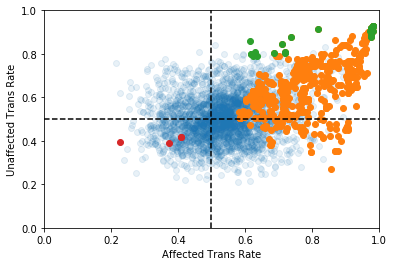

In [54]:
plt.scatter(np.hstack(transrates_both_aff)[np.hstack(ind_indices)], np.hstack(transrates_both_unaff)[np.hstack(ind_indices)], alpha=0.1)

cutoff = 3
indices = -np.log10(np.vstack(posterior_pvalues_both_aff))[:, 0]>=cutoff
plt.scatter(np.hstack(transrates_both_aff)[indices], np.hstack(transrates_both_unaff)[indices])
indices = -np.log10(np.vstack(posterior_pvalues_both_unaff))[:, 0]>=cutoff
plt.scatter(np.hstack(transrates_both_aff)[indices], np.hstack(transrates_both_unaff)[indices])
indices = -np.log10(np.vstack(posterior_pvalues_both_aff))[:, 1]>=cutoff
plt.scatter(np.hstack(transrates_both_aff)[indices], np.hstack(transrates_both_unaff)[indices])
indices = -np.log10(np.vstack(posterior_pvalues_both_unaff))[:, 1]>=cutoff
plt.scatter(np.hstack(transrates_both_aff)[indices], np.hstack(transrates_both_unaff)[indices])

plt.xlabel('Affected Trans Rate')
plt.ylabel('Unaffected Trans Rate')
plt.axhline(0.5, color='black', linestyle='--')
plt.axvline(0.5, color='black', linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])

plt.show()

In [55]:
for i, chrom in enumerate(chroms):
    print(chrom)
    for j in np.where(-np.log10(posterior_pvalues_ihart_aff[i][:, 0]) > cutoff)[0]:
        d = all_collections[i][j].deletion
        print('%s%s:%d-%d %d %d %0.2f' % ('*' if ind_indices[i][j] else '', 
                                       d.chrom, d.opt_start_pos, d.opt_end_pos, d.length, 
                                          j, -np.log10(posterior_pvalues_both_unaff[i][j, 0])))
        print(np.hstack((contingency_ihart_aff[i][j], contingency_ssc_aff[i][j])))
        print(np.hstack((contingency_ihart_unaff[i][j], contingency_ssc_unaff[i][j])))
    
    

1
1:7558790-7559645 856 195 0.65
[[ 0.  4.  0.  0.]
 [ 2. 30.  0.  3.]
 [ 3. 14.  0.  0.]
 [ 0.  0.  0.  0.]]
[[0. 1. 0. 0.]
 [0. 0. 0. 3.]
 [1. 3. 0. 0.]
 [0. 0. 0. 0.]]
*1:7558790-7559842 1024 196 0.65
[[ 0.  4.  0.  0.]
 [ 2. 32.  0.  3.]
 [ 3. 14.  0.  0.]
 [ 0.  0.  0.  0.]]
[[0. 1. 0. 0.]
 [0. 0. 0. 3.]
 [1. 3. 0. 0.]
 [0. 0. 0. 0.]]
1:7558790-7559977 1158 198 0.94
[[ 0.  3.  0.  0.]
 [ 1. 31.  0.  3.]
 [ 5. 13.  0.  0.]
 [ 0.  0.  0.  0.]]
[[0. 0. 0. 0.]
 [0. 0. 0. 3.]
 [1. 5. 0. 0.]
 [0. 0. 0. 0.]]
1:13122835-13132174 9213 300 0.33
[[  0.  16.   0.   0.]
 [ 44. 165.   2.  10.]
 [ 39.  60.   0.   0.]
 [  0.   2.   0.   0.]]
[[ 0.  1.  0.  0.]
 [ 0.  7.  2. 10.]
 [14. 13.  0.  0.]
 [ 1.  1.  0.  0.]]
*1:12909354-13132174 8322 302 0.35
[[  0.  18.   0.   0.]
 [ 44. 165.   2.  11.]
 [ 39.  60.   0.   0.]
 [  0.   2.   0.   0.]]
[[ 0.  1.  0.  0.]
 [ 0.  7.  2. 11.]
 [14. 13.  0.  0.]
 [ 1.  1.  0.  0.]]
*1:25650551-25655757 5167 651 1.06
[[ 0.  0.  0.  0.]
 [ 7. 29.  1.  5.]
 [ 2. 

 [0. 0. 0. 0.]]
9:66989297-66989598 249 1183 1.03
[[ 0. 14.  0.  0.]
 [15. 67.  0.  0.]
 [ 3. 17.  0.  0.]
 [ 0.  0.  0.  0.]]
[[0. 1. 0. 0.]
 [0. 2. 0. 0.]
 [0. 4. 0. 0.]
 [0. 0. 0. 0.]]
9:66988965-66989616 267 1185 1.03
[[ 0. 14.  0.  0.]
 [14. 76.  0.  0.]
 [ 3. 17.  0.  0.]
 [ 0.  0.  0.  0.]]
[[0. 6. 0. 0.]
 [0. 2. 0. 0.]
 [0. 4. 0. 0.]
 [0. 0. 0. 0.]]
9:66989256-66989598 249 1187 1.03
[[ 0. 15.  0.  0.]
 [15. 73.  0.  0.]
 [ 3. 17.  0.  0.]
 [ 0.  0.  0.  0.]]
[[0. 6. 0. 0.]
 [0. 2. 0. 0.]
 [0. 4. 0. 0.]
 [0. 0. 0. 0.]]
9:66988965-66989588 239 1188 1.03
[[ 0. 15.  0.  0.]
 [14. 74.  0.  0.]
 [ 2. 12.  0.  0.]
 [ 0.  0.  0.  0.]]
[[0. 6. 0. 0.]
 [0. 2. 0. 0.]
 [0. 4. 0. 0.]
 [0. 0. 0. 0.]]
9:66988965-66989616 90 1203 0.80
[[ 0. 12.  0.  0.]
 [12. 73.  0.  0.]
 [ 3. 13.  0.  0.]
 [ 0.  0.  0.  0.]]
[[0. 6. 0. 0.]
 [0. 3. 0. 0.]
 [0. 2. 0. 0.]
 [0. 0. 0. 0.]]
9:85839194-85840684 1361 1550 2.59
[[ 0.  4.  0.  0.]
 [ 1. 53.  3.  7.]
 [ 0. 13.  0.  0.]
 [ 0.  0.  0.  0.]]
[[ 0.  1.  0.

[[  0.  15.   0.   0.]
 [ 17. 100.   9.  17.]
 [ 11.  35.   0.   0.]
 [  2.   5.   0.   0.]]
[[ 0.  0.  0.  0.]
 [ 1.  6.  4. 22.]
 [ 5. 12.  0.  0.]
 [ 1.  0.  0.  0.]]
12:98669735-98672590 2658 1789 1.21
[[  0.  17.   0.   0.]
 [ 39. 132.   9.  18.]
 [ 27.  58.   0.   0.]
 [  4.   7.   0.   0.]]
[[ 0.  0.  0.  0.]
 [ 4.  9.  4. 23.]
 [12. 23.  0.  0.]
 [ 1.  0.  0.  0.]]
12:98669735-98672007 2018 1790 1.10
[[  0.  16.   0.   0.]
 [ 38. 125.  16.  29.]
 [ 25.  56.   0.   0.]
 [  6.   6.   0.   0.]]
[[ 0.  0.  0.  0.]
 [ 4.  9. 11. 34.]
 [12. 21.  0.  0.]
 [ 1.  3.  0.  0.]]
12:98670126-98672303 2173 1795 1.33
[[  0.  16.   0.   0.]
 [ 39. 136.  17.  30.]
 [ 27.  60.   0.   0.]
 [  5.   8.   0.   0.]]
[[ 0.  0.  0.  0.]
 [ 4.  9. 11. 36.]
 [12. 24.  0.  0.]
 [ 1.  2.  0.  0.]]
12:98669735-98672502 1642 1796 1.62
[[  0.  15.   0.   0.]
 [ 17. 100.   9.  18.]
 [ 11.  35.   0.   0.]
 [  2.   5.   0.   0.]]
[[ 0.  0.  0.  0.]
 [ 1.  6.  4. 23.]
 [ 5. 12.  0.  0.]
 [ 1.  0.  0.  0.]]
12:986

In [127]:
print([(x.family, x.family_size) for x in all_collections[20][274].matches])

[('AU2096.AU2096202.AU2096201', 5), ('AU0123.AU012301.AU012302', 5), ('13568.13568.mo.13568.fa', 4), ('AU0906.AU0906202.AU0906201', 6), ('AU0025.AU002501.AU002502', 4), ('12733.12733.mo.12733.fa', 4), ('AU1576.AU1576202.AU1576201', 5), ('11098.11098.mo.11098.fa', 4), ('13001.13001.mo.13001.fa', 4), ('13503.13503.mo.13503.fa', 4), ('AU2865.AU2865202.AU2865201', 6), ('13001.13001.mo.13001.fa', 4), ('AU3302.AU3302202.AU3302201', 4), ('11993.11993.mo.11993.fa', 4), ('AU0953.AU0953202.AU0953201', 4), ('12424.12424.mo.12424.fa', 4), ('AU0899.AU089901.AU089902', 5), ('12662.12662.mo.12662.fa', 4), ('13503.13503.mo.13503.fa', 4), ('AU1844.AU1844202.AU1844201', 4), ('12041.12041.mo.12041.fa', 4), ('AU3303.AU3303202.AU3303201', 4), ('11561.11561.mo.11561.fa', 4), ('AU0579.AU057901.AU057902', 5), ('AU1821.AU1821202.AU1821201', 4), ('AU1576.AU1576202.AU1576201', 5), ('AU0157.AU015701.AU015702', 4), ('AU2352.AU2352202.AU2352201', 4), ('AU3197.AU3197202.AU3197201', 5), ('12518.12518.mo.12518.fa', 4)

In [130]:
print([[(child_id_to_sex[y], y in x.trans) for y in family_to_individuals[x.family][2:]] for x in all_collections[20][274].matches])





[[('1', True), ('2', False), ('2', True)], [('1', True), ('2', True), ('2', False)], [('1', True), ('2', True)], [('2', False), ('1', True), ('2', False), ('1', True)], [('1', True), ('1', True)], [('1', False), ('2', True)], [('1', True), ('1', False), ('1', True)], [('2', True), ('1', True)], [('1', False), ('1', True)], [('1', True), ('1', False)], [('2', True), ('1', True), ('1', True), ('2', True)], [('1', True), ('1', False)], [('1', True), ('1', True)], [('1', True), ('1', False)], [('1', True), ('1', True)], [('1', True), ('2', False)], [('1', True), ('1', False), ('1', True)], [('1', False), ('1', True)], [('1', False), ('1', True)], [('1', True), ('1', True)], [('1', True), ('1', False)], [('1', True), ('1', False)], [('1', False), ('1', True)], [('1', True), ('1', True), ('1', True)], [('2', True), ('1', False)], [('1', True), ('1', True), ('1', True)], [('2', False), ('1', True)], [('1', True), ('1', True)], [('1', True), ('1', True), ('2', True)], [('1', True), ('2', True)

# Check sex-bias

In [131]:
contingency_ihart_m = create_contingency(all_collections, ihart_family_sizes, lambda child_id, is_mat, dataset: child_id_to_sex[child_id]=='1' and dataset == 'iHART')
contingency_ihart_f = create_contingency(all_collections, ihart_family_sizes, lambda child_id, is_mat, dataset: child_id_to_sex[child_id]=='2' and dataset == 'iHART')


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 

In [133]:
transrates_ihart_m = [btr.calculate_transmission_rates(contingency_ihart_m[i], ihart_family_sizes) for i in range(len(chroms))]
transrates_ihart_f = [btr.calculate_transmission_rates(contingency_ihart_f[i], ihart_family_sizes) for i in range(len(chroms))]
    

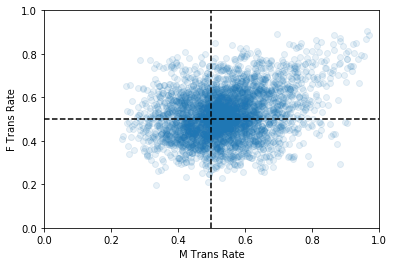

In [143]:
plt.scatter(np.hstack(transrates_ihart_m)[np.hstack(ind_indices)], np.hstack(transrates_ihart_f)[np.hstack(ind_indices)], alpha=0.1)

plt.xlabel('M Trans Rate')
plt.ylabel('F Trans Rate')
plt.axhline(0.5, color='black', linestyle='--')
plt.axvline(0.5, color='black', linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])

plt.show()

In [134]:
posteriors_ihart_m = [btr.calculate_posteriors(contingency_ihart_m[i], ihart_family_sizes) for i in range(len(chroms))]
posteriors_ihart_f = [btr.calculate_posteriors(contingency_ihart_f[i], ihart_family_sizes) for i in range(len(chroms))]


In [135]:
overlap_ihart_mf = [btr.calculate_posterior_overlap(posteriors_ihart_m[i], posteriors_ihart_f[i]) for i in range(len(chroms))]
posterior_pvalues_ihart_m = [btr.calculate_posterior_pvalue(posteriors_ihart_m[i]) for i in range(len(chroms))]
posterior_pvalues_ihart_f =  [btr.calculate_posterior_pvalue(posteriors_ihart_f[i]) for i in range(len(chroms))]



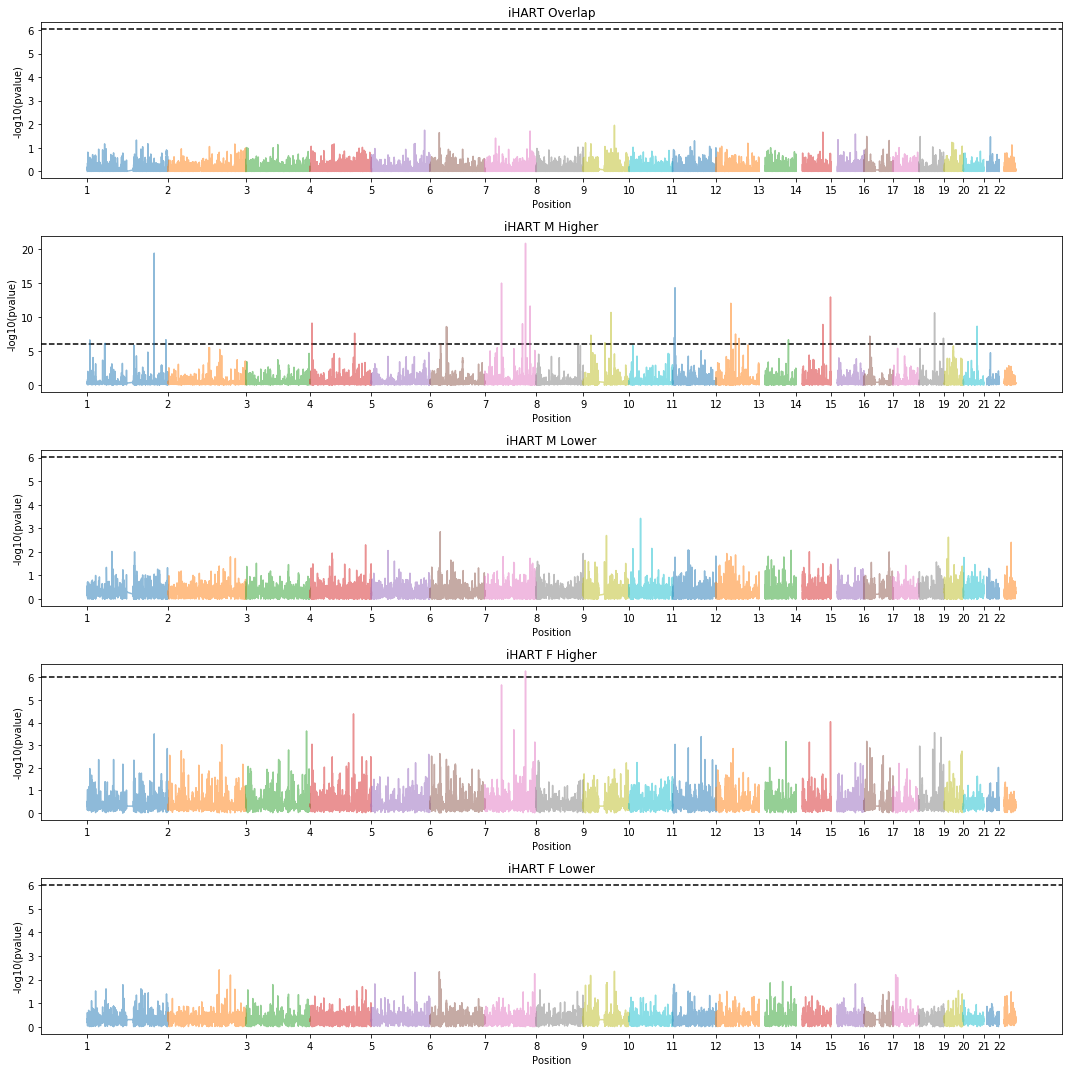

In [138]:
plt.figure(figsize=(15, 15))
 
cutoff = -np.log10(0.05/sum([len(contingency_both_aff[i]) for i in range(len(chroms))]))
#cutoff = -np.log10(0.05/len(all_collections))

titles = ['iHART Overlap', 'iHART M Higher', 'iHART M Lower', 'iHART F Higher', 'iHART F Lower']

for i, title in enumerate(titles):
    plt.subplot(5, 1, i+1)
    plt.axhline(cutoff, linestyle='--', color='black')
    plt.ylabel('-log10(pvalue)')
    plt.xlabel('Position')
    plt.xticks(chrom_offsets[:-1], chroms)
    plt.title(title)

for i, chrom in enumerate(chroms):
    positions = chrom_offsets[i] + np.array([c.deletion.start_pos for c in all_collections[i]])
    plt.subplot(5, 1, 1)
    plt.plot(positions, -np.log10(overlap_ihart_mf[i]), alpha=0.5)
    plt.subplot(5, 1, 2)
    plt.plot(positions, -np.log10(posterior_pvalues_ihart_m[i][:, 0]), alpha=0.5)
    plt.subplot(5, 1, 3)
    plt.plot(positions, -np.log10(posterior_pvalues_ihart_m[i][:, 1]), alpha=0.5)
    plt.subplot(5, 1, 4)
    plt.plot(positions, -np.log10(posterior_pvalues_ihart_f[i][:, 0]), alpha=0.5)
    plt.subplot(5, 1, 5)
    plt.plot(positions, -np.log10(posterior_pvalues_ihart_f[i][:, 1]), alpha=0.5)
    
plt.tight_layout()
plt.show()

In [147]:
for i, chrom in enumerate(chroms):
    print(chrom)
    for j in np.where(-np.log10(posterior_pvalues_ihart_aff[i][:, 0]) > cutoff)[0]:
        d = all_collections[i][j].deletion
        print('%s%s:%d-%d %d %d %0.2f' % ('*' if ind_indices[i][j] else '', 
                                       d.chrom, d.opt_start_pos, d.opt_end_pos, d.length, 
                                          j, -np.log10(posterior_pvalues_both_unaff[i][j, 0])))
        print(np.hstack((contingency_ihart_aff[i][j], contingency_ssc_aff[i][j])))
        print(np.hstack((contingency_ihart_unaff[i][j], contingency_ssc_unaff[i][j])))
    
        print(posterior_pvalues_ihart_m[i][j, :])

1
1:7558790-7559842 1024 203 0.80
[[ 0.  0.  0.  0.]
 [ 0. 29.  0.  4.]
 [ 2. 17.  0.  0.]
 [ 0.  0.  0.  0.]]
[[0. 0. 0. 0.]
 [0. 0. 0. 3.]
 [0. 2. 0. 0.]
 [0. 0. 0. 0.]]
[2.17473697e-07 9.99999791e-01]
1:207541572-207547252 5681 3602 3.27
[[ 0.  1.  0.  0.]
 [ 0. 87.  0. 39.]
 [ 0. 13.  0.  0.]
 [ 0.  0.  0.  0.]]
[[ 0.  0.  0.  0.]
 [ 0.  2.  0. 16.]
 [ 0.  4.  0.  0.]
 [ 0.  0.  0.  0.]]
[5.86449478e-19 1.00000000e+00]
1:207541572-207546544 4973 3605 4.69
[[ 0.  1.  0.  0.]
 [ 0. 93.  0. 47.]
 [ 1. 14.  0.  0.]
 [ 0.  0.  0.  0.]]
[[ 0.  0.  0.  0.]
 [ 0.  3.  0. 24.]
 [ 0.  4.  0.  0.]
 [ 0.  0.  0.  0.]]
[5.21618199e-19 1.00000000e+00]
1:207541572-207546630 5059 3606 4.69
[[ 0.  1.  0.  0.]
 [ 0. 93.  0. 47.]
 [ 0. 13.  0.  0.]
 [ 0.  0.  0.  0.]]
[[ 0.  0.  0.  0.]
 [ 0.  3.  0. 24.]
 [ 0.  4.  0.  0.]
 [ 0.  0.  0.  0.]]
[3.68877126e-20 1.00000000e+00]
1:207541572-207547252 5213 3610 3.27
[[ 0.  1.  0.  0.]
 [ 0. 87.  0. 38.]
 [ 0. 13.  0.  0.]
 [ 0.  0.  0.  0.]]
[[ 0.  0.  0.